In [3]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [4]:
BA_csv = Path("../ASD_Data/BA_DATA.csv")

In [5]:
BA_df = pd.read_csv(BA_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [6]:
BA_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-06-30,73.000000,74.099998,72.900002,73.930000,59.705540,4245300
2011-07-01,73.809998,74.730003,73.800003,74.269997,59.980122,3647800
2011-07-05,74.169998,74.730003,73.849998,74.150002,59.883221,3130300
2011-07-06,74.129997,75.160004,74.010002,74.739998,60.359699,3757800
2011-07-07,75.330002,76.199997,74.849998,75.989998,61.369186,4976900


In [7]:
BA_df.sort_index(ascending=True, inplace=True)

In [8]:
BA_df = BA_df.rename(columns={'Close': 'Close'})
BA_df = BA_df[['Close']]
BA_df

,Close
Date,
2011-06-30,73.930000
2011-07-01,74.269997
2011-07-05,74.150002
2011-07-06,74.739998
2011-07-07,75.989998
...,...
2021-06-24,250.570007
2021-06-25,248.380005
2021-06-28,239.960007


In [9]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [11]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(BA_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[73.93     74.269997 74.150002 74.739998 75.989998 75.07     73.349998
  71.93     72.169998 71.190002 71.279999 69.550003 70.529999 72.07
  72.889999 72.669998 71.309998 70.160004 70.629997 70.660004 70.470001
  70.330002 67.699997 67.339996 63.09     62.75     58.709999 62.34
  57.41     58.849998 61.75     62.700001 62.23     62.18     58.93
  57.540001 58.380001 60.77     61.689999 61.099998 62.799999 64.599998
  66.029999 66.860001 66.050003 64.029999 62.77     64.900002 62.810001
  61.790001 62.389999 62.849998 63.029999 64.32     65.379997 64.150002
  63.560001 61.02     58.720001 59.509998 62.009998 62.779999 61.919998
  62.369999 60.509998 58.25     59.139999 59.959999 61.48     61.810001
  64.029999 63.970001 64.32     63.529999 63.889999 61.779999 63.470001
  63.110001 62.490002 64.589996 64.75     63.720001 66.559998 67.489998
  68.169998 65.790001 63.169998 64.400002 66.190002 65.800003 66.290001
  66.650002 64.550003 64.830002 66.919998 67.940002 67.9400

In [12]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [13]:
y_train

array([[ 65.559998],
       [ 64.349998],
       [ 62.360001],
       ...,
       [239.75    ],
       [238.089996],
       [238.740005]])

In [14]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [15]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [18]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape= (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True
    ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units
    ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [20]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 10s 303ms/step - loss: 0.0063
Epoch 2/20
15/15 [==============================] - 5s 318ms/step - loss: 0.0163
Epoch 3/20
15/15 [==============================] - 5s 318ms/step - loss: 0.0159
Epoch 4/20
15/15 [==============================] - 5s 323ms/step - loss: 0.0099
Epoch 5/20
15/15 [==============================] - 5s 327ms/step - loss: 0.0220
Epoch 6/20
15/15 [==============================] - 7s 505ms/step - loss: 0.0155
Epoch 7/20
15/15 [==============================] - 10s 656ms/step - loss: 0.0090
Epoch 8/20
15/15 [==============================] - 11s 744ms/step - loss: 0.0032
Epoch 9/20
15/15 [==============================] - 12s 805ms/step - loss: 0.0020
Epoch 10/20
15/15 [==============================] - 12s 789ms/step - loss: 0.0017
Epoch 11/20
15/15 [==============================] - 12s 798ms/step - loss: 0.0020
Epoch 12/20
15/15 [==============================] - 12s 823ms/step - loss: 0.0016
Epoch 13/20
15/15 

In [21]:
model.evaluate(X_test, y_test, verbose=0)

0.018783077597618103

In [22]:
predicted = model.predict(X_test)

In [23]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [24]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [25]:
BA_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = BA_df.index[-len(real_prices): ])

BA_actual_predicted.head()

,Actual,Predicted
Date,,
2017-08-28,235.889999,247.391144
2017-08-29,237.179993,247.416000
2017-08-30,240.490005,247.426254
2017-08-31,240.460007,247.512283
2017-09-01,239.660004,247.692734


In [26]:
BA_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-06-24,243.570007,257.528412
2021-06-25,250.570007,256.707031
2021-06-28,248.380005,256.205841
2021-06-29,239.960007,256.002838
2021-06-30,235.759995,255.822998


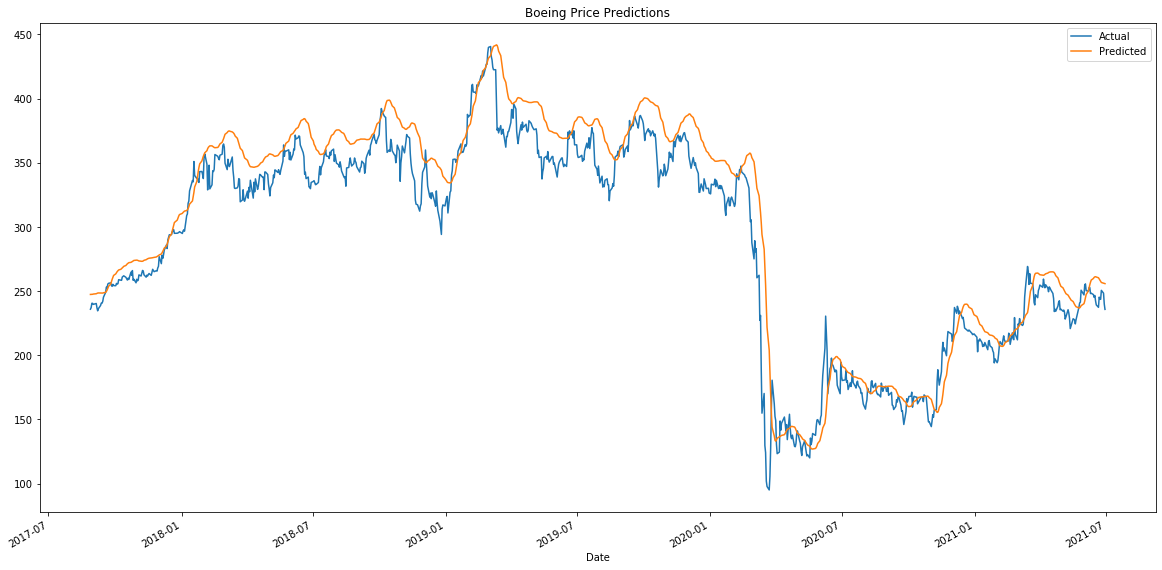

In [30]:
BA_actual_predicted.plot(figsize=(20,10), title="Boeing Price Predictions")